In [3]:
import torch
import numpy as np
import pandas as pd

In [62]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt

In [60]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

In [7]:
# Import main dataset
df = pd.read_csv("../AUTEXTIFICATION/subtask_1/train.tsv", sep="\t")
df = df.drop("id", axis=1)

# Import additional dataset as test (only generated)
#dff = pd.read_csv("../AUTEXTIFICATION/subtask_2/train.tsv", sep="\t")
#dff = dff.drop("id", axis=1)
#dff["label"] = dff["label"].apply(lambda x: "generated")

df

,text,label
0,you need to stop the engine and wait until it ...,generated
1,The Commission shall publish the report; an in...,generated
2,"I have not been tweeting a lot lately, but I d...",generated
3,I pass my exam and really thankgod for that bu...,human
4,The template will have 3 parts: a mustache sha...,human
...,...,...
33840,"@PierreJoye i have a server already, thanks fo...",human
33841,10. Article 13 of Council Directive 80/777/EEC...,human
33842,"Crying because I have to cry for you?. No. No,...",generated
33843,"However, it will continue to offer customers a...",generated


In [8]:
df['label'] = df['label'].replace({'human':0, 'generated':1})
#dff['label'] = df['label'].replace({'human':0, 'generated':1})

In [9]:
df

,text,label
0,you need to stop the engine and wait until it ...,1
1,The Commission shall publish the report; an in...,1
2,"I have not been tweeting a lot lately, but I d...",1
3,I pass my exam and really thankgod for that bu...,0
4,The template will have 3 parts: a mustache sha...,0
...,...,...
33840,"@PierreJoye i have a server already, thanks fo...",0
33841,10. Article 13 of Council Directive 80/777/EEC...,0
33842,"Crying because I have to cry for you?. No. No,...",1
33843,"However, it will continue to offer customers a...",1


In [10]:
train, test = train_test_split(df, test_size=0.2)

In [11]:
# Per ora uso il validation come test, perchè il dataset di test dà problemi
data = DatasetDict()
data['train'] = Dataset.from_pandas(train)
data['validation'] = Dataset.from_pandas(test)
data['test'] = Dataset.from_pandas(test)

In [12]:
model_name = 'bert-base-multilingual-uncased'

categories = ['human', 'generated']

bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(categories))

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [13]:
bert = bert.to(device)

In [14]:
print(bert)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [15]:
for param in bert.parameters():
    print(param.size(), param.requires_grad)

torch.Size([105879, 768]) True
torch.Size([512, 768]) True
torch.Size([2, 768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([3072, 768]) True
torch.Size([3072]) True
torch.Size([768, 3072]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([3072, 768]) True
torch.Size([3072]) True
torch.Size([768, 3072]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768,

In [16]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [18]:
# TODO max_length è hardcoded, devo fixare
def tokenize_function(examples):
    return tokenizer(examples["text"], padding='max_length', truncation=True, max_length=135)

tokenized_data = data.map(tokenize_function, batched=True)

In [22]:
training_args = TrainingArguments(
    "free_bird", 
    per_device_train_batch_size=8,
    num_train_epochs=3
)

In [23]:
trainer = Trainer(
    model=bert, 
    args=training_args, 
    train_dataset=tokenized_data['train'], 
    eval_dataset=tokenized_data['validation']
)

In [24]:
trainer.train()

/home/crimsowl/.conda/envs/tf/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.555700
1000,0.452600
1500,0.424200
2000,0.428700
2500,0.408500
3000,0.372700
3500,0.342300
4000,0.285400
4500,0.282000
5000,0.320700


TrainOutput(global_step=10155, training_loss=0.292306570581824, metrics={'train_runtime': 793.9105, 'train_samples_per_second': 102.314, 'train_steps_per_second': 12.791, 'total_flos': 5635191305948400.0, 'train_loss': 0.292306570581824, 'epoch': 3.0})

In [25]:
trainer.evaluate()

{'eval_loss': 0.4134037494659424,
 'eval_runtime': 14.3283,
 'eval_samples_per_second': 472.423,
 'eval_steps_per_second': 59.114,
 'epoch': 3.0}

In [41]:
preds = trainer.predict(tokenized_data['validation'])
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
#label_names = test.target_names
print(classification_report(test.iloc[:,1].values, y_pred)) #target_names=label_names

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      3458
           1       0.87      0.96      0.91      3311

    accuracy                           0.91      6769
   macro avg       0.91      0.91      0.91      6769
weighted avg       0.92      0.91      0.91      6769



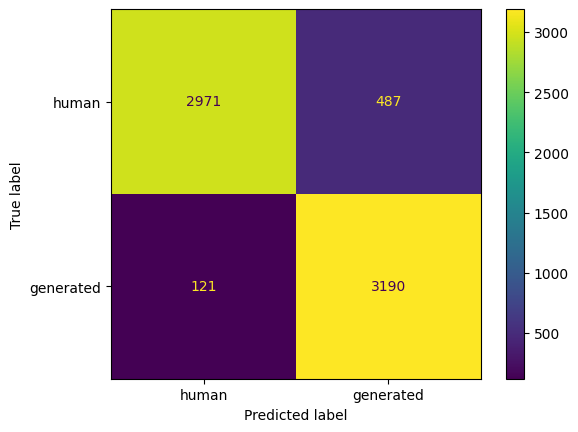

In [63]:
cm = confusion_matrix(test.iloc[:,1].values, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['human', 'generated'])
cm_display.plot()
plt.show()

In [44]:
@torch.no_grad()
def predict(text):
    input_encodings = tokenizer(text, return_tensors='pt').to(device)
    outputs = bert(**input_encodings)
    
    label_names = ['human', 'generated']
    
    lbl = label_names[torch.argmax(outputs.logits).item()]

    return lbl

In [68]:
# This is text generated by ChatGPT when prompted:
# "Explain in a short sentence why the natural language processing field is cool"
sample_text = 'The natural language processing field is cool because it enables machines to understand, interpret, and generate human language, which has numerous real-world applications.' 
predict(sample_text)

'generated'